In [68]:
#| default_exp fid

FID

In [69]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg
from frechetdist import frdist

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from types import SimpleNamespace
from diffusers import UNet2DModel

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [70]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8


In [71]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [72]:
b = xb,yb = next(iter(dls.train))

In [73]:
cbs = [DeviceCB(), MixedPrecision()] 
model = torch.load('models/data_aug3.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)


We need a measure of how close our generated images are to images in the original dataset.  One way we can do that is by comparing the activations across the channels at the layer just after our last resblock. The idea is similar to concepts used in style transfer. We will use the covariance matrix of the activations as our comparison.

In [74]:
? model[6] 
# Flatten layer after avg pool from final resblock

Signature:       model[6](*args, **kwargs)
Type:           Flatten
String form:    Flatten(start_dim=1, end_dim=-1)
File:           ~/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/nn/modules/flatten.py
Docstring:     
Flattens a contiguous range of dims into a tensor. For use with :class:`~nn.Sequential`.
See :meth:`torch.flatten` for details.

Shape:
    - Input: :math:`(*, S_{\text{start}},..., S_{i}, ..., S_{\text{end}}, *)`,'
      where :math:`S_{i}` is the size at dimension :math:`i` and :math:`*` means any
      number of dimensions including none.
    - Output: :math:`(*, \prod_{i=\text{start}}^{\text{end}} S_{i}, *)`.

Args:
    start_dim: first dim to flatten (default = 1).
    end_dim: last dim to flatten (default = -1).

Examples::
    >>> input = torch.randn(32, 1, 5, 5)
    >>> # With default parameters
    >>> m = nn.Flatten()
    >>> output = m(input)
    >>> output.size()
    torch.Size([32, 25])
    >>> # With non-default parameters
    >>> m = nn.Flatten(

We can pull these activations using a callback

In [75]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [76]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [77]:
learn.fit(1, train=False, cbs=[hcb])

In [78]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

Another callback approach

In [79]:
hcb = HooksCallback(append_outp, mod_filter=fc.risinstance(nn.Flatten), on_valid=True)

In [80]:
learn.fit(1, train=False, cbs=[hcb])

In [81]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

Or we can just knock the final two layers off our model

In [82]:
del(learn.model[8])
del(learn.model[7])

In [83]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

In [84]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [85]:
lr = 1e-2

n_steps = 1000
lin_abar = linear_sched(betamax=0.02)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [86]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [87]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [88]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [89]:
smodel = torch.load('models/fashion_ddpm2.pkl').cuda()


In [90]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(x_t, t_batch).sample
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [91]:
%%time
samples = sample(smodel, (64, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 25.6 s, sys: 44.4 ms, total: 25.7 s
Wall time: 25.6 s


In [92]:
s = samples[-1]
s.mean(), s.std(), s.min(), s.max()

(tensor(-0.57), tensor(0.65), tensor(-1.05), tensor(1.59))

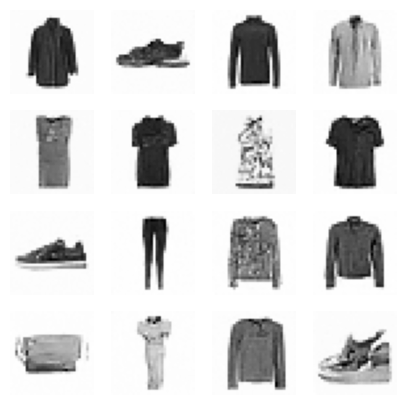

In [93]:
show_images(samples[-1][:16], figsize=(5,5))

In [94]:
clearn = TrainLearner(model, DataLoaders([],[(s,yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([64, 512])

In [95]:
# activation means
means = feats.mean(0)
means.shape, feats.shape

(torch.Size([512]), torch.Size([10000, 512]))

In [96]:
#Covariance of features
covs = feats.T.cov()
covs.shape, type(covs)

(torch.Size([512, 512]), torch.Tensor)

In [97]:
#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [98]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [99]:

#|export
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [100]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)

In [101]:
feats2.shape

torch.Size([64, 512])

1685.1514892578125

In [102]:
_calc_fid(*s1, *s2)

144.2314453125

In [5]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        print('test')
        self.model = model; self.cbs = cbs
        self.learn1 = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn1.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)
        print(self.feats.shape)
        

    def get_feats(self, samp):
        self.learn2 = TrainLearner(self.model, DataLoaders([],[(samp, tensor([0]))]), loss_func=fc.noop, cbs=self.cbs, opt_func=None)
        return self.learn2.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): 
        n_feats = self.get_feats(samp)
        print(n_feats.shape)
        print("originals..")
        o_feats = self.learn1.capture_preds()[0].float().cpu().squeeze()[:len(n_feats)]
        print(o_feats.shape)

        return _calc_fid(*_calc_stats(o_feats), *_calc_stats(n_feats))
    def fid2(self, samp): 
        return frdist(self.feats[:len(self.get_feats(samp))], self.get_feats(samp))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [104]:
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [105]:
P=[[1,1], [2,1], [2,2]]
Q=[[2,2], [0,1], [2,4]]
frdist(P,Q)

2.0

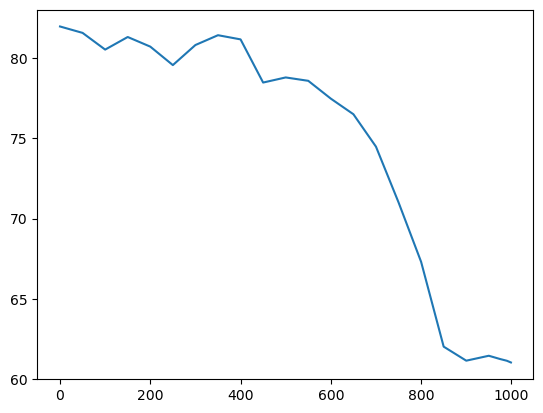

In [106]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid2(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

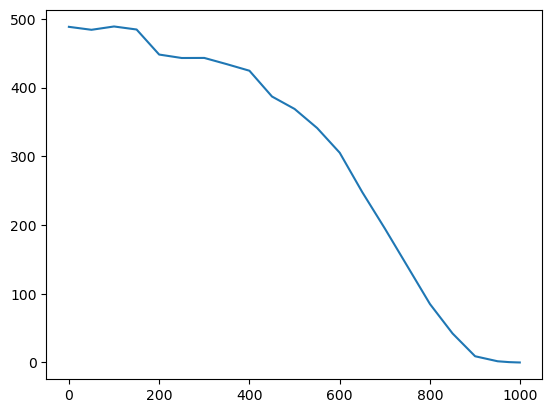

In [107]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [6]:
import nbdev; nbdev.nbdev_export()

In [109]:
clean_mem()